Importing the libraries and dataset

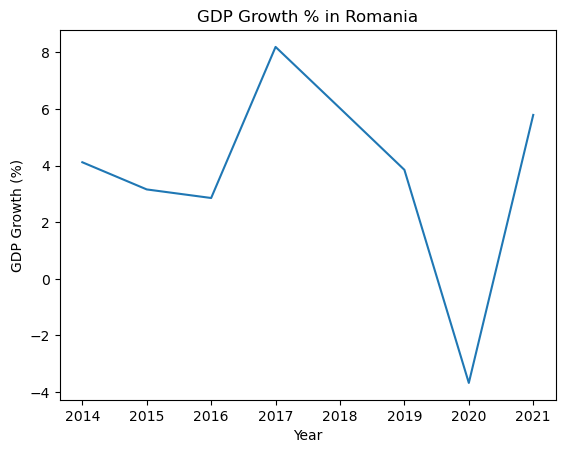

    Country  Year  Int Pen Rate %  GDP Per Capita  GDP Growth %  \
64  Romania  2014       54.080000     18424.27982      4.120675   
65  Romania  2015       55.763156     19096.13105      3.160504   
66  Romania  2016       59.503951     19754.81299      2.857546   
67  Romania  2017       63.747282     21497.91857      8.196507   
68  Romania  2018       70.681278     22928.33973      6.029019   

    Urbanization Rate %  
64               53.900  
65               53.887  
66               53.900  
67               53.936  
68               53.998  


In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data = pd.read_csv('Datasets\merged_data_panel.csv', sep=',')
data.columns = list(map(str.strip, data.columns)) # Aligning column names
# Filter the data for Romania
romania_data = data[data['Country'] == 'Romania']
#romania_data.drop('Urbanization Rate %', axis=1, inplace=True)

plt.plot(romania_data['Year'], romania_data['GDP Growth %'])
plt.xlabel('Year')
plt.ylabel('GDP Growth (%)')
plt.title('GDP Growth % in Romania')
plt.show()

print(romania_data.head())
# Set the index to the Year column
romania_data.set_index('Year', inplace=True)

Autocorrelation and Partial Autocorrelation

c:\Users\Iustin\anaconda3\envs\DataScience\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


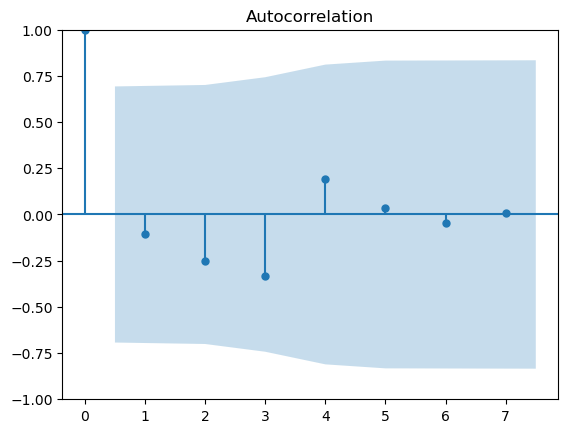

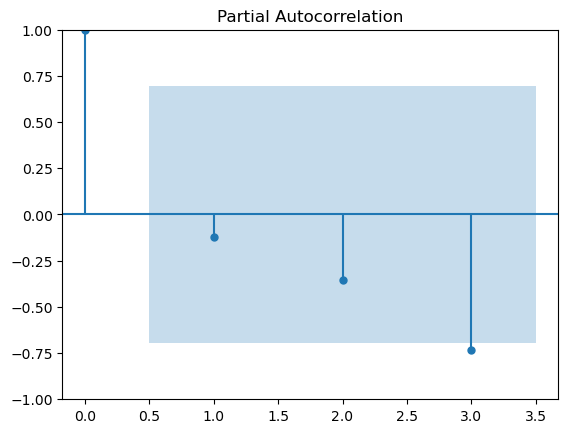

In [3]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics import tsaplots

gdp_growth = romania_data[['GDP Growth %']]

# Autocorrelation plot
plot_acf(gdp_growth)

# Partial Autocorrelation plot
fig = tsaplots.plot_pacf(gdp_growth, lags=3)

# q = 2, because only 2 lines exceed the threshold

1st Order Differencing and Autocorrelation 

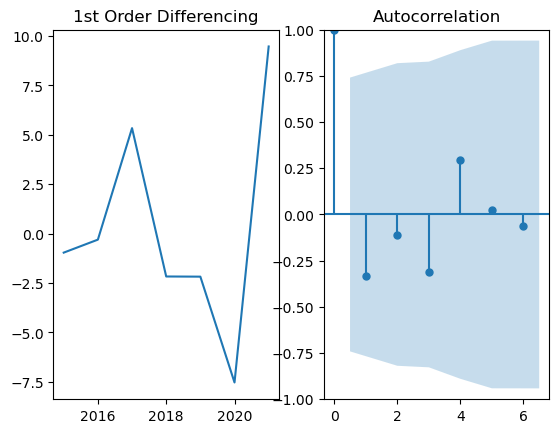

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics import tsaplots

gdp_growth = romania_data["GDP Growth %"]
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(gdp_growth.diff())

ax2 = f.add_subplot(122)
plot_acf(gdp_growth.diff().dropna(), ax = ax2)
plt.show()

2nd Order Differencing and Autocorrelation

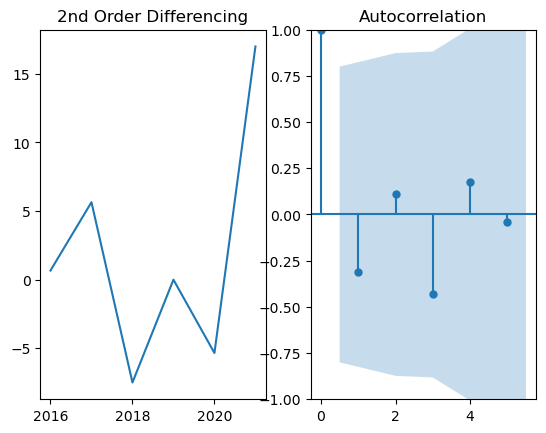

In [5]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(gdp_growth.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(gdp_growth.diff().diff().dropna(), ax = ax2)
plt.show()

# The 2nd Order Differencing plot proves to be more statistically significant than the 1st Order Differencing plot
# p = 1, number of autoregressive terms

Augmented Dickey-Fuller test for stationarity

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(gdp_growth.dropna())
print('p-value:', result[1])

result = adfuller(gdp_growth.diff().dropna())
print('p-value:', result[1])

result = adfuller(gdp_growth.diff().diff().dropna())
print('p-value:', result[1])

# As we compare the values below, we can see that after the 1st order differencing, the p-value drops below the acceptable threshold of 0.05.
# So the data is stationary.
# Thus we can consider the "d" parameter: number of nonseasonal differencing = 1/2.

p-value: 4.817468200949898e-16
p-value: 0.0851728400975319
p-value: 0.16671333074487427


Building ARIMA Model for GDP Growth %

c:\Users\Iustin\anaconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Iustin\anaconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Iustin\anaconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Iustin\anaconda3\envs\DataScience\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Iustin\an

                               SARIMAX Results                                
Dep. Variable:           GDP Growth %   No. Observations:                    8
Model:                 ARIMA(1, 2, 2)   Log Likelihood                 -19.443
Date:                Tue, 18 Jul 2023   AIC                             46.887
Time:                        11:54:59   BIC                             46.054
Sample:                             0   HQIC                            43.552
                                  - 8                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8838      2.281     -0.387      0.698      -5.354       3.587
ma.L1         -0.3236    515.259     -0.001      0.999   -1010.213    1009.566
ma.L2         -0.6752    353.002     -0.002      0.9

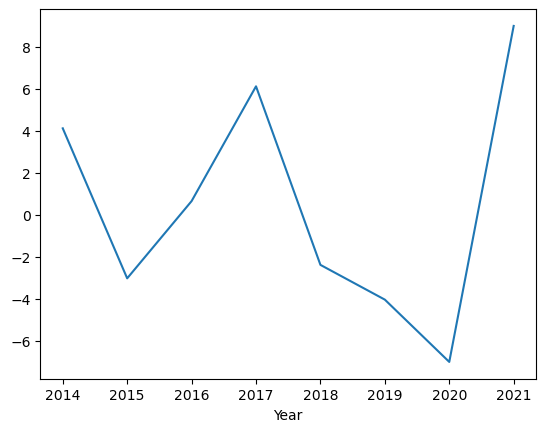

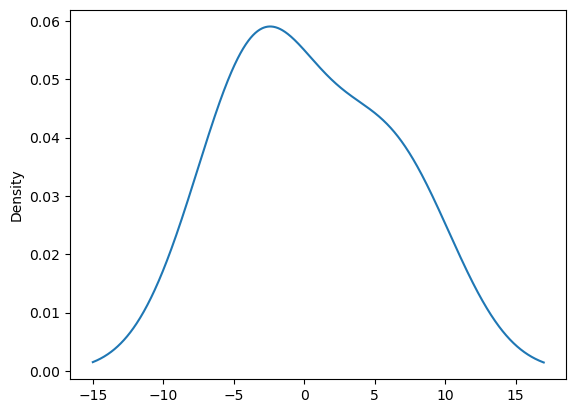

count    8.000000
mean     0.432441
std      5.533719
min     -6.999515
25%     -3.273989
50%     -0.861373
75%      4.620613
max      8.995699
dtype: float64


In [13]:
# Define the order for the ARIMA model
order = (1, 2, 2)

# Create the ARIMA model for GDP Growth %
model_pen_rate = ARIMA(romania_data['GDP Growth %'], order=order)
model_pen_rate_fit = model_pen_rate.fit()
# Predict the GDP Growth % for 2022, 2023 and 2024
forecast_gdp_growth = model_pen_rate_fit.forecast(steps=3)

print(model_pen_rate_fit.summary())

# Plot of residual erros
residuals = model_pen_rate_fit.resid
residuals.plot()
plt.show()

# Density plot of residuals
residuals.plot(kind='kde')
plt.show()

# Summary stats of residuals
print(residuals.describe())

# The plot of residuals confirms stationarity.
# The second plot is a density plot of residuals, suggesting the errors are non-Gaussian.

Visualizing the predictions for years 2022, 2023 and 2024


GDP Growth % forecast:
8     2.493815
9     5.267847
10    2.674409
Name: predicted_mean, dtype: float64


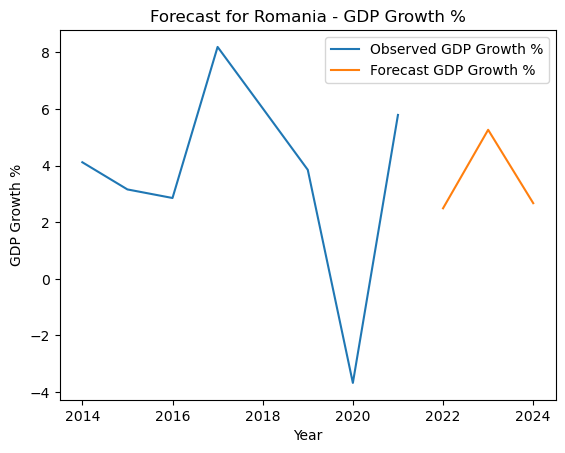

In [14]:
# Print the forecasted values

print("\nGDP Growth % forecast:")
print(forecast_gdp_growth)

plt.plot(romania_data.index, romania_data['GDP Growth %'], label='Observed GDP Growth %')
plt.plot([2022, 2023, 2024], forecast_gdp_growth, label='Forecast GDP Growth %')
plt.xlabel('Year')
plt.ylabel('GDP Growth %')
plt.title('Forecast for Romania - GDP Growth %')
plt.legend()
plt.show()